### RQ Analyser for different sources

#### Questions and To Do list
- Why does the first file has a lot of triggers with weird baseline? This happens for all type of traces, aslo noise traces.
- Adapt noise trace selection to remove pulses, harder autocutting?
- Currently, the PSD in PyCRP is calculated almost only using the first file, it is also calculated for each source independently, this might lead to differences in the OF outcomes.


#### Imports

In [1]:
import joblib
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

import RQ_helper

Working directory: /home/wvdp/Documents/scratch
nptdms not available, skip for Argonne data.
No local midas libary installed


/home/wvdp/Documents/pycrp/pycrp/_event.py:34: UserWarning: No MIDAS reader found. See readme for how to install a python MIDAS interface.
  warnings.warn(


#### Constants

In [2]:
# Directories
globus_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/"
output_dir = globus_dir+"output/"

# Default matplotlib colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# Define 2D configs
config_2d_scatter = {"type":"scatter"}
config_2d_hist = {"type":"hist"}

# Field initizlisation
source_dict = {}
config = None

#### Load data

In [3]:
fn_list = glob(globus_dir+"processed/OFResults*.joblib")

for i, fn in enumerate(fn_list):
    series = re.search("OFResults_(.*?)_", fn).group(1)
    path = re.search("OFResults_(.*).joblib", fn).group(1)
    print("---",series, path)

    source_dict[series] = {}
    source_dict[series]['path'] = path
    source_dict[series]['fn'] = fn
    source_dict[series]['creation_time'] = os.path.getctime(source_dict[series]['fn'])
    source_dict[series]['data'] = joblib.load(fn)
    source_dict[series]['color'] = colors[i]
    exec(source_dict[series]['data']['config_str'])
    source_dict[series]['config'] = config
    source_dict[series]['helper'] = RQ_helper.RQ_helper(source_dict[series]['data'], config, path, output_dir)
    del config
    print(series, datetime.fromtimestamp(source_dict[series]['creation_time']),fn)

series_names = list(source_dict.keys())

# check if all configs are the same
configs = [source_dict[series]['config'] for series in series_names]
for configs_i in configs:
    if configs_i != configs[0]:
        raise ValueError("Not all configs are the same")
config = configs[0]

--- AmBe AmBe_August
RQ helper is initialised
AmBe 2023-03-11 14:22:58 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_AmBe_August.joblib
--- Background Background_workingpoint_August
RQ helper is initialised
Background 2023-03-11 15:53:15 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Background_workingpoint_August.joblib
--- Ba133 Ba133_August
RQ helper is initialised
Ba133 2023-03-11 14:59:42 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Ba133_August.joblib
--- Co60 Co60_August
RQ helper is initialised
Co60 2023-03-11 12:55:40 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Co60_August.joblib


#### Add new fields

For list of existing fields: 
https://bitbucket.org/phys-ricochet/pycrp/src/master/pycrp/processing/

In [4]:
raw_trace_length = config.real_trace_length

for series, sample_d in source_dict.items():
    RQ_data = sample_d["data"]

    # Time since previous triggered pulse
    trig_loc_tr = RQ_data["trig_loc"]
    num_traces_file = max(RQ_data["trig_traceidx"]+1)
    trace_loc = RQ_data["trig_traceidx"]
    file_loc = RQ_data["trig_fileidx"]
    num_files = max(RQ_data["trig_fileidx"]+1)

    trig_loc_total = (file_loc*num_traces_file+trace_loc)*raw_trace_length + trig_loc_tr
    time_diffs_trig = np.diff(trig_loc_total[RQ_data["trig_ch"] == 1])/config.Fs
    time_diffs_trig = np.insert(time_diffs_trig, 0, trig_loc_tr[0])
    time_diffs_noise = np.diff(trig_loc_total[RQ_data["trig_ch"] == 0])/config.Fs
    time_diffs_noise = np.insert(time_diffs_noise, 0, trig_loc_tr[0])

    RQ_data["time_diff_prev_trig"] = np.empty_like(RQ_data['trig_ch'], dtype=float)
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 1] = time_diffs_trig
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 0] = time_diffs_noise
    RQ_data["trig_loc_total"] = trig_loc_total

    # Maximum value of the tail, baseline subtracted
    RQ_data["MaxTailRel_CH1"] = RQ_data["MaxTail_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["TailAmpFraction_CH1"] = RQ_data["MaxTailRel_CH1"] / RQ_data["Amplitude_CH1"]
    # Maximum value of the head, baseline subtracted
    RQ_data["MaxHeadRel_CH1"] = RQ_data["MaxHead_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["HeadAmpFraction_CH1"] = RQ_data["MaxHeadRel_CH1"] / RQ_data["Amplitude_CH1"]

    # Data quality cuts
    ## Pycrp trigger channel
    ## Tail amplitude needs to be less than 99% of the pulse amplitude
    ## Head amplitude needs to be less than 99% of the pulse amplitude
    ## OFL time needs to be greater than 0 and less than 5 ms -> TODO, this was the older version.
    mask_trig_quality = (RQ_data['trig_ch'] == 1) &\
        (RQ_data["TailAmpFraction_CH1"] < 0.99) &\
        (RQ_data["HeadAmpFraction_CH1"] < 0.99) &\
        (RQ_data['OFL_time_CH1'] > -0.005) & (RQ_data['OFL_time_CH1'] < 0.010)
       #(RQ_data["time_diff_prev_trig"] > 0.1) &\

    if "Fe55" in series:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 3.5e-6) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 1e-7) &\
            (RQ_data["trig_amp"] > 1.5)

    elif "August" in series:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 2e-5) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 4e-7)

    # Define Masks
    ## Noise triggers
    mask_noise = (RQ_data['trig_ch'] == 0) & (RQ_data["trig_fileidx"]!=0)
    ## TES-like pulses
    mask_tes = (RQ_data['trig_ch'] == 1) & (RQ_data['Amplitude_CH1'] /RQ_data['Integral_CH1'] > 0.003) & (RQ_data['Amplitude_CH1'] > 0.02) & (RQ_data["trig_fileidx"]!=0)
    ## Crystal-like pulses
    mask_crystal = mask_trig_quality & (~mask_tes) & (RQ_data["trig_fileidx"]!=0)
    ## Weird traces
    mask_noisy = ~mask_noise & ~mask_trig_quality & ~mask_tes

    RQ_data["mask_crystal"] = mask_crystal
    RQ_data["mask_tes"] = mask_tes
    RQ_data["mask_noise"] = mask_noise
    RQ_data["mask_noisy"] = mask_noisy


    # Duration of the data taking:
    sample_d["duration"] = RQ_helper.get_duration(trig_loc_total, mask_crystal, config.Fs)
    # Print summary
    print(f"\n--- {series}, pre-trigger: {config.PRE_TRIG}, post-trigger: {config.POST_TRIG}, baseline: {config.BaseLength}, tail: {config.TailLength} ---")
    print('Duration of data taking after quality cuts:', int(sample_d["duration"]/60), 'minutes')
    print('Original triggered events:', sum(RQ_data['trig_ch']))
    print('After quality cuts:', sum(mask_trig_quality))
    print('TES-like pulses:', sum(mask_tes))
    print('Crystal-like pulses', sum(mask_crystal))
    trig_amp_threshold = RQ_data['trig_config']['CH1']['trigger_threshold']
    print("The auto threshold was set to", RQ_data['trig_config']['CH1']
          ['trigger_threshold_auto'], "which was calculated to be", trig_amp_threshold)



--- AmBe, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 999 minutes
Original triggered events: 142080
After quality cuts: 127265
TES-like pulses: 1124
Crystal-like pulses 114485
The auto threshold was set to None which was calculated to be 4

--- Background, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 1099 minutes
Original triggered events: 76080
After quality cuts: 71378
TES-like pulses: 421
Crystal-like pulses 65156
The auto threshold was set to None which was calculated to be 4

--- Ba133, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 799 minutes
Original triggered events: 63810
After quality cuts: 57654
TES-like pulses: 377
Crystal-like pulses 51058
The auto threshold was set to None which was calculated to be 4

--- Co60, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, t

#### Show some noise and pulse traces

In [5]:
plot_pulses = False
if plot_pulses:
    n_pulses = 10

    for series,sample_d in source_dict.items():
        RQ_data = sample_d["data"]
        helper = sample_d["helper"]

        # Noise pulses
        mask_noise = RQ_data["mask_noise"]
        mask_sample = RQ_helper.sample_from_mask(mask_noise,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" Noise pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG, post_trig=config.POST_TRIG)

        # TES-like pulses
        mask_tes = RQ_data["mask_tes"]
        mask_sample = RQ_helper.sample_from_mask(mask_tes,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" TES-like pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=0, post_trig=config.POST_TRIG/4)

        # Crystal-like pulses
        mask_crystal = RQ_data["mask_crystal"]
        mask_sample = RQ_helper.sample_from_mask(mask_crystal,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" Crystal-like pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG/4, post_trig=config.POST_TRIG)

#### Plot a single variable  for a single series

Text(0, 0.5, '# Pulses')

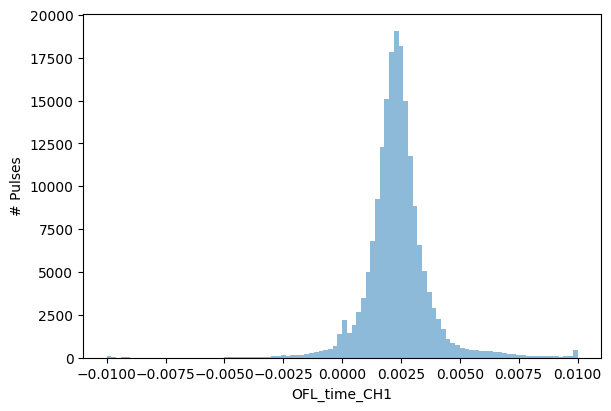

In [6]:
## settings
series = "Co60"
field = "OFL_time_CH1"
x_range = (-0.01,0.01)
bins=100
mask = source_dict[series]["data"]['trig_ch']==1
## --------

data = source_dict[series]["data"][field]
fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)

ax.hist(data[mask], range=x_range, bins=bins, alpha=0.5)
ax.set_xlabel(field)
ax.set_ylabel('# Pulses')

#### Calculate pulse rates

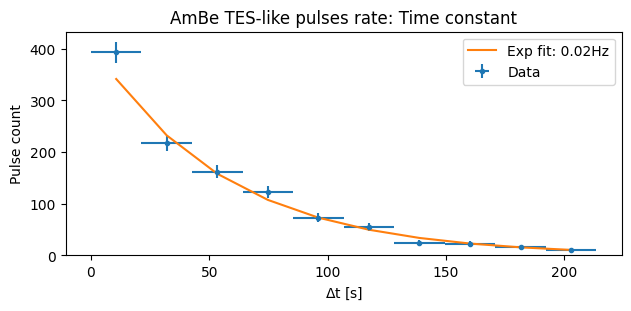

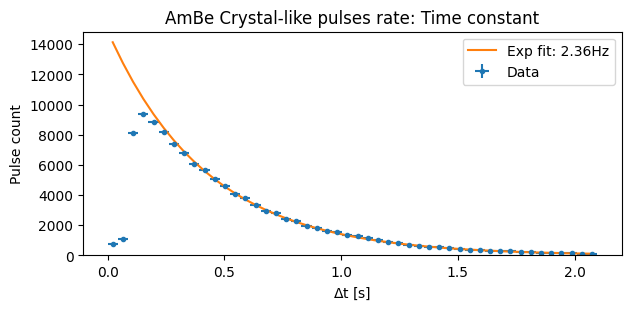

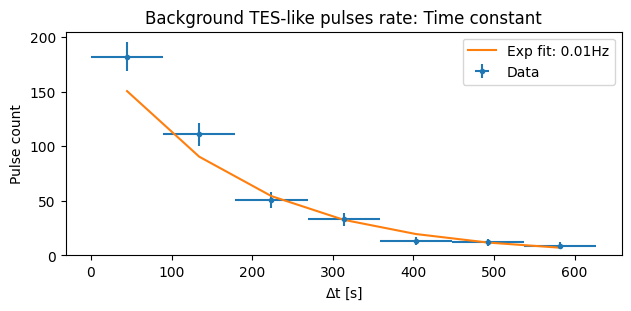

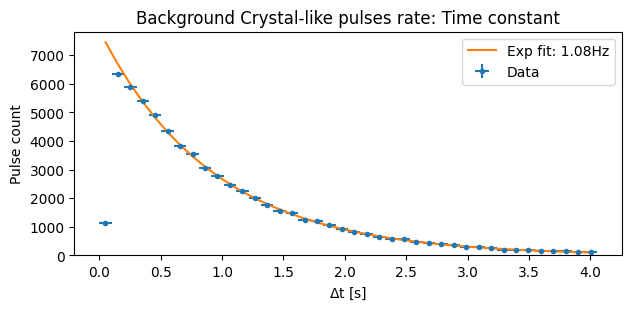

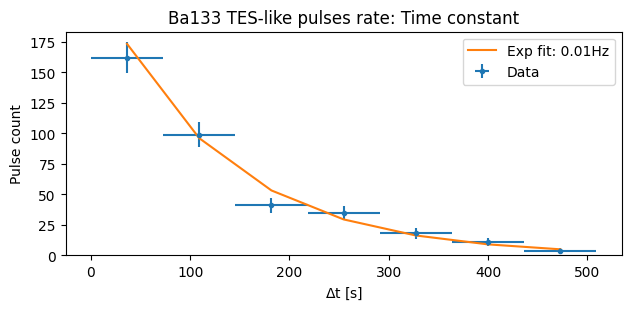

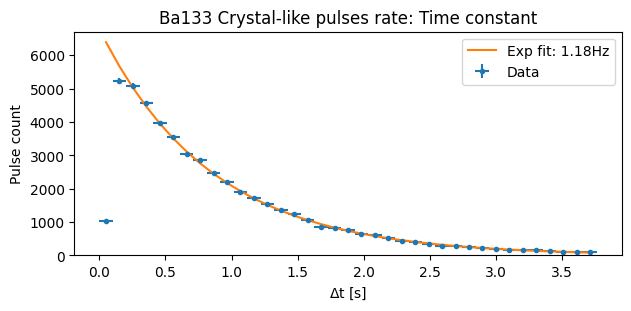

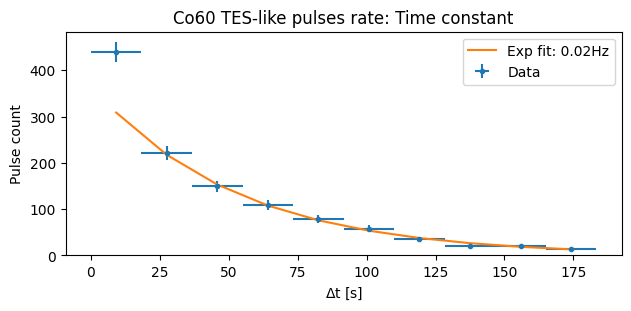

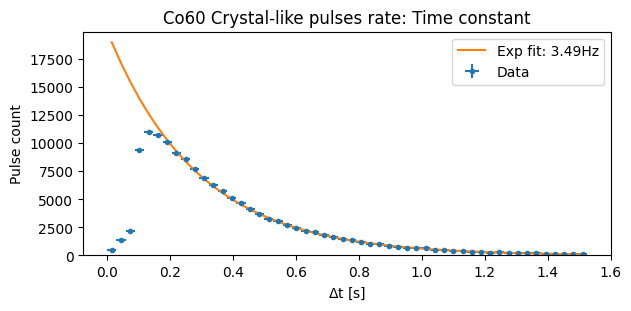

In [7]:
for series,sample_d in source_dict.items():
    # TES-like pulses
    sample_d["helper"].get_pulse_rate(sample_d["data"]["mask_tes"], series+" TES-like pulses", sample_d["duration"])
    # Crystal-like pulses
    sample_d["rate"] = sample_d["helper"].get_pulse_rate(sample_d["data"]["mask_crystal"], series+" Crystal-like pulses", sample_d["duration"])
    sample_d['normalisation'] = sample_d['rate']*24*3600/sum(sample_d["data"]["mask_crystal"])

#### Plot histograms comparing sources

((<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_CH1', ylabel='# Pulses/day/bin'>),
 (<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_CH1', ylabel='# Pulses/day/bin [Background Subtracted]'>))

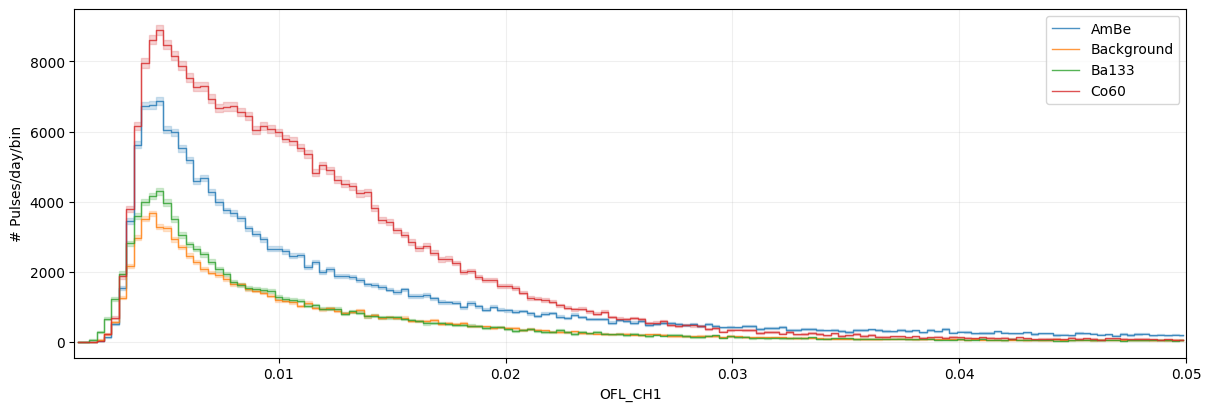

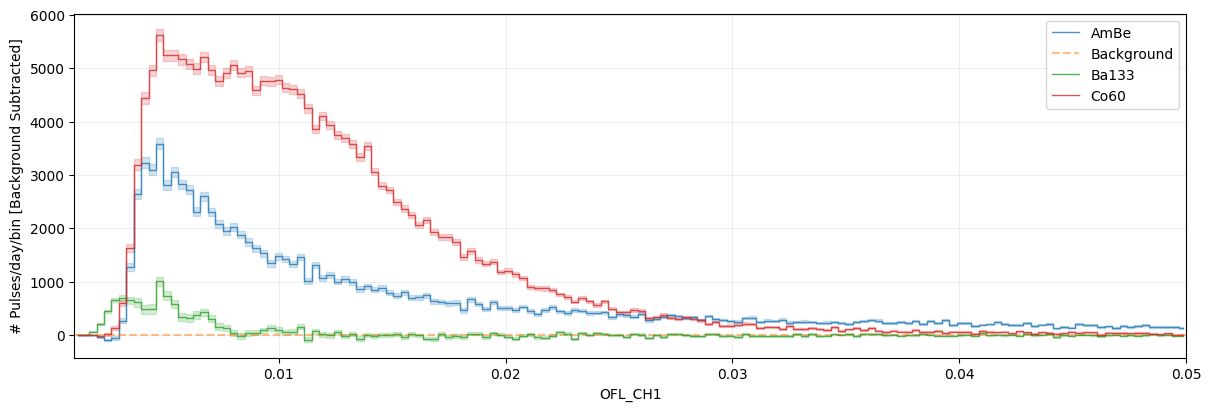

In [8]:
field = 'OFL_CH1'
mask = 'mask_crystal'
x_range = (0.001,0.05)
bins = 150
RQ_helper.plot_var_comparison(source_dict, field, mask, x_range, bins, log_flag=False, save_fig=True, output_dir=output_dir)

((<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin'>),
 (<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin [Background Subtracted]'>))

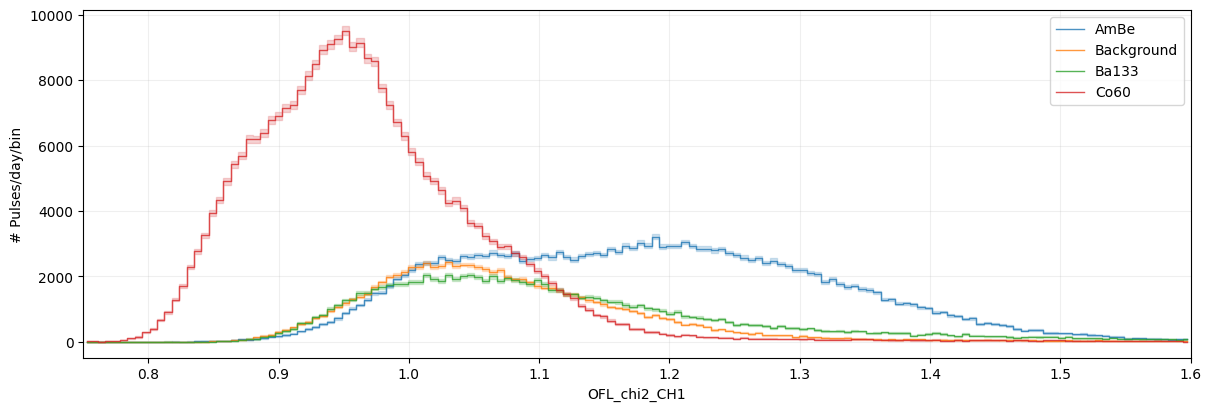

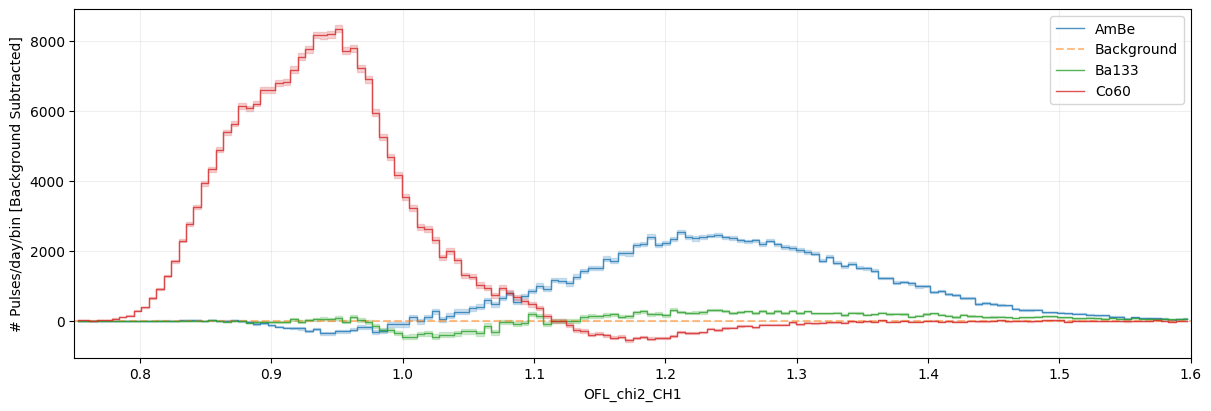

In [9]:
field = 'OFL_chi2_CH1'
mask = 'mask_crystal'
x_range = (0.75,1.6)
bins = 150
RQ_helper.plot_var_comparison(source_dict, field, mask, x_range, bins, log_flag=False, save_fig=True, output_dir=output_dir)

#### Investigate pulse shape differences

In [10]:
pulse_shape_differences = False
if pulse_shape_differences:
      # AmBe Pulses: OFL_chi2_CH1 in [1.25, 1.3], Integral_CH1 in [15,20]
      n_pulses = 200
      mask = source_dict["AmBe"]['data']["mask_crystal"] &\
            (source_dict["AmBe"]['data']["OFL_chi2_CH1"]>1.25) & (source_dict["AmBe"]['data']["OFL_chi2_CH1"]<1.3) &\
            (source_dict["AmBe"]['data']["Integral_CH1"]>85) & (source_dict["AmBe"]['data']["Integral_CH1"]<100)
      mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
      print(sum(mask_sample))
      times, traces_AmBe = source_dict["AmBe"]['helper'].plot_traces(mask_sample, r"AmBe pulses with $\chi^2$ in [1.25,1.30]", plot_data=0, nsmooth=100, plot_mean=0.5, max_nevents=n_pulses)

      # Co60 Pulses: OFL_chi2_CH1 in [0.95, 1], Integral_CH1 in [15,20]
      mask = source_dict["Co60"]['data']["mask_crystal"] &\
            (source_dict["Co60"]['data']["OFL_chi2_CH1"]>0.95) & (source_dict["Co60"]['data']["OFL_chi2_CH1"]<1) &\
            (source_dict["Co60"]['data']["Integral_CH1"]>85) & (source_dict["Co60"]['data']["Integral_CH1"]<100)
      mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
      times, traces_Co60 = source_dict["Co60"]['helper'].plot_traces(mask_sample, r"Co60 pulses with $\chi^2$ in [0.95,1.00]", plot_data=0, nsmooth=100, plot_mean=0.5, max_nevents=n_pulses)


      fig, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True)
      ax.plot(times, traces_AmBe.mean(axis=1), alpha=0.5, label="AmBe", color=source_dict["AmBe"]['color'])
      ax.plot(times, traces_Co60.mean(axis=1), alpha=0.5, label="Co60", color=source_dict["Co60"]['color'])

      times_template = np.arange(-config.PRE_TRIG, config.POST_TRIG)/config.Fs*1000
      template = joblib.load(config.DEFAULT_TEMPLATE_FULL_PATH)["CH1"]
      template_int = np.trapz(template, times_template)
      ax.plot(times_template, template/template_int, alpha=0.8, label="OF template", color='green')
      ax.set_xlabel('Time [ms]')
      ax.set_ylabel(r'TES current [$\mu$A]')
      ax.set_title("Comparison of avarage pulses and OF template")
      ax.grid(alpha=0.2)
      ax.set_xlim(min(times),max(times))
      ax.legend()


#### Pulse discrimination in 2D

(0.75, 1.6)

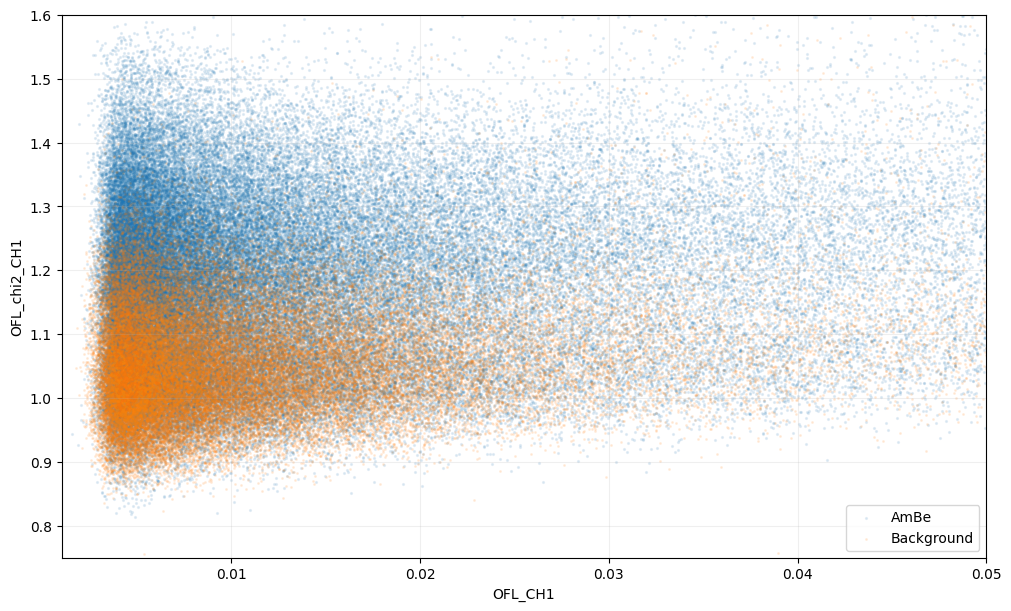

In [11]:
fig, ax  = plt.subplots(figsize=(10,6), constrained_layout=True)

mask = 'mask_crystal'
field_x = 'OFL_CH1'
field_y = 'OFL_chi2_CH1'
x_range = (0.001,0.05)
y_range = (0.75,1.6)

select_samples = ['Background', 'AmBe']

for k,v in source_dict.items():
    if k in select_samples:
        data_x = v['data'][field_x][v['data'][mask]]
        data_y = v['data'][field_y][v['data'][mask]]
        ax.scatter(data_x, data_y, alpha=0.1, s=v['normalisation'],label=k)

ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(field_x)
ax.set_ylabel(field_y)
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)

#### 2D plots for a single source

In [12]:
mask_arr = ["mask_noise", "mask_crystal", "mask_noisy"] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']

mask_noise 1
mask_crystal 1
mask_noisy 3


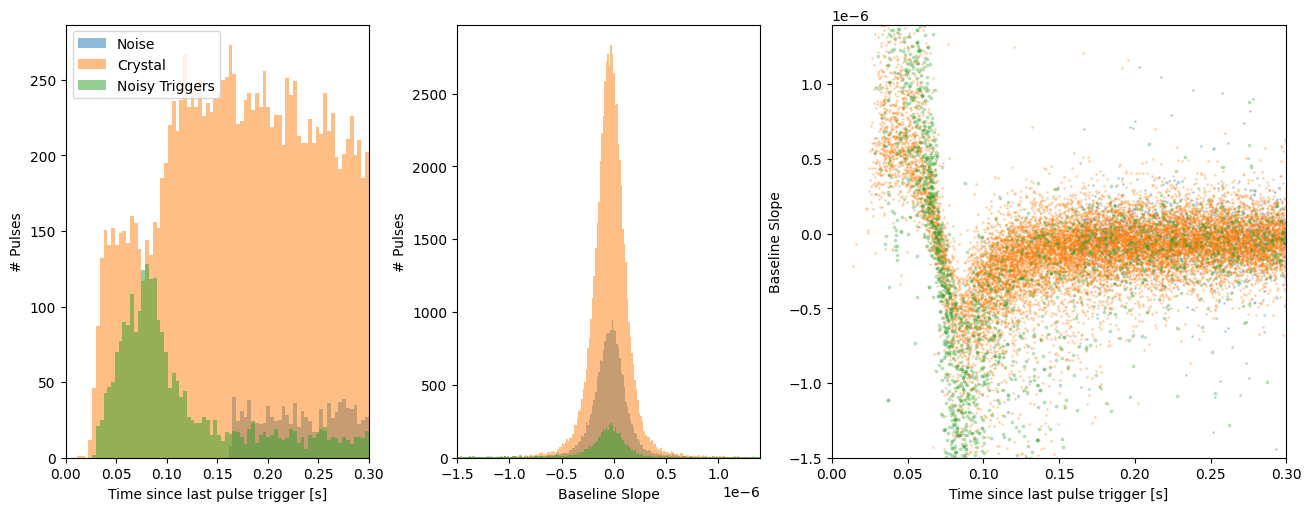

In [13]:
# Investigate pilup pulse cut
series = "Background"

var1 = {'name': 'time_diff_prev_trig',
        'label': 'Time since last pulse trigger [s]',
        'range': (0,0.3),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineSlope_CH1',
        'label': 'Baseline Slope',
        'range': (-1.5e-6,1.4e-6),
        'bins': 200,
        'norm':False
       }

fix,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

mask_noise 1
mask_crystal 1
mask_noisy 3


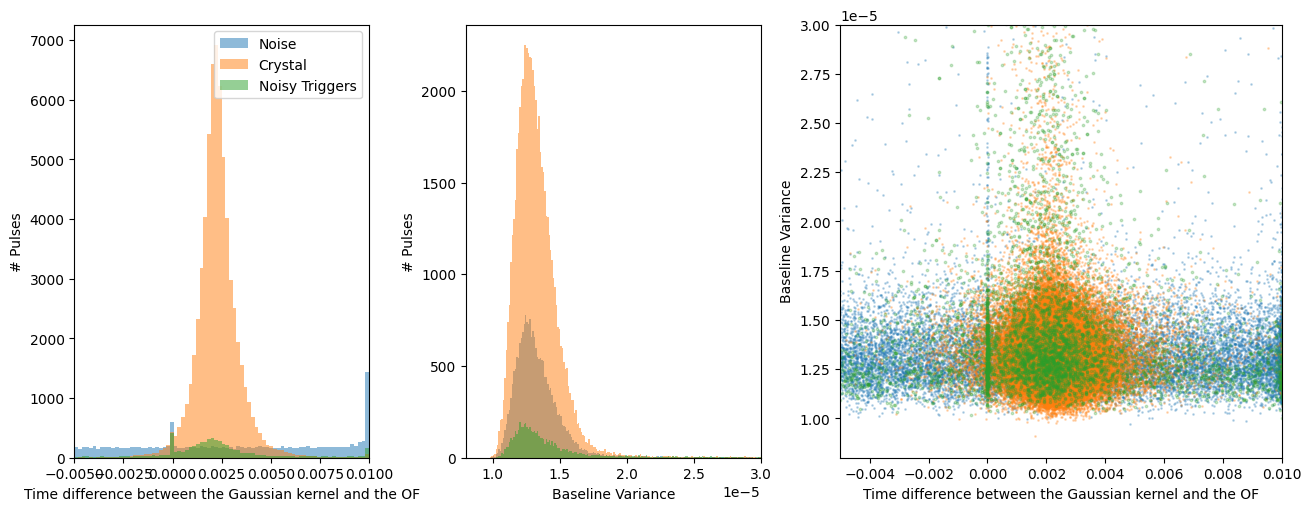

In [14]:
# Investigate pilup pulse cut
var1 = {'name': 'OFL_time_CH1',
        'label': 'Time difference between the Gaussian kernel and the OF',
        'range': (-0.005,0.01),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineVariance_CH1',
        'label': 'Baseline Variance',
        'range': (8e-6,3e-5),
        'bins': 200,
        'norm':False
       }

fix,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)